# Bot Detection Analysis Overview

This notebook provides comprehensive analysis of bot detection results:
- Distribution of scores across different detection methods
- Top most likely bots
- Correlations between detection methods
- LLM prompt comparisons (DeepSeek + Claude)

In [17]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data from Database

In [18]:
# Connect to database
conn = sqlite3.connect('bot_detection.db')

# Load bot detection results
bot_results = pd.read_sql_query("""
    SELECT * FROM bot_detection_results
""", conn)

# Load DeepSeek analyses
deepseek = pd.read_sql_query("""
    SELECT * FROM deepseek_analyses
""", conn)

# Load user metadata
users = pd.read_sql_query("""
    SELECT * FROM users
""", conn)

print(f"Loaded {len(bot_results)} bot detection results")
print(f"Loaded {len(deepseek)} DeepSeek analyses")
print(f"Loaded {len(users)} users")

Loaded 1007 bot detection results
Loaded 3988 DeepSeek analyses
Loaded 1007 users


## 1.1 Filter Out Failed LLM Analyses

In [19]:
# Filter out entries where LLM failed (confidence = 0 or null)
print("Before filtering:")
print(f"  Bot results: {len(bot_results)}")
print(f"  DeepSeek analyses: {len(deepseek)}")

# Filter DeepSeek: Remove entries where confidence is 0 or null
deepseek_original_count = len(deepseek)
deepseek = deepseek[(deepseek['confidence'] > 0) & (deepseek['confidence'].notna())]
deepseek_removed = deepseek_original_count - len(deepseek)

# Filter bot_results: Remove entries where llm_analysis_score is null or 0
# (indicating LLM analysis failed)
bot_results_original_count = len(bot_results)
bot_results = bot_results[
    (bot_results['llm_analysis_score'].notna()) & 
    (bot_results['llm_analysis_score'] > 0) &
    (bot_results['confidence'] > 0) &
    (bot_results['confidence'].notna())
]
bot_results_removed = bot_results_original_count - len(bot_results)

print("\nAfter filtering:")
print(f"  Bot results: {len(bot_results)} (removed {bot_results_removed})")
print(f"  DeepSeek analyses: {len(deepseek)} (removed {deepseek_removed})")
print(f"\n✓ Filtered out {deepseek_removed + bot_results_removed} total entries where LLM failed or certainty = 0")

Before filtering:
  Bot results: 1007
  DeepSeek analyses: 3988

After filtering:
  Bot results: 539 (removed 468)
  DeepSeek analyses: 3986 (removed 2)

✓ Filtered out 470 total entries where LLM failed or certainty = 0


## 2. Overall Statistics

In [20]:
print("=" * 60)
print("BOT DETECTION STATISTICS")
print("=" * 60)
print(f"\nTotal users analyzed: {len(bot_results)}")
print(f"\nOverall Bot Score Distribution:")
print(bot_results['overall_score'].describe())
print(f"\nBots (score >= 0.6): {len(bot_results[bot_results['overall_score'] >= 0.6])}")
print(f"Humans (score <= 0.4): {len(bot_results[bot_results['overall_score'] <= 0.4])}")
print(f"Uncertain (0.4 < score < 0.6): {len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])}")

BOT DETECTION STATISTICS

Total users analyzed: 539

Overall Bot Score Distribution:
count    539.000000
mean       0.166637
std        0.083162
min        0.012500
25%        0.112500
50%        0.170000
75%        0.212500
max        0.512500
Name: overall_score, dtype: float64

Bots (score >= 0.6): 0
Humans (score <= 0.4): 530
Uncertain (0.4 < score < 0.6): 9


## 3. Score Distributions by Method

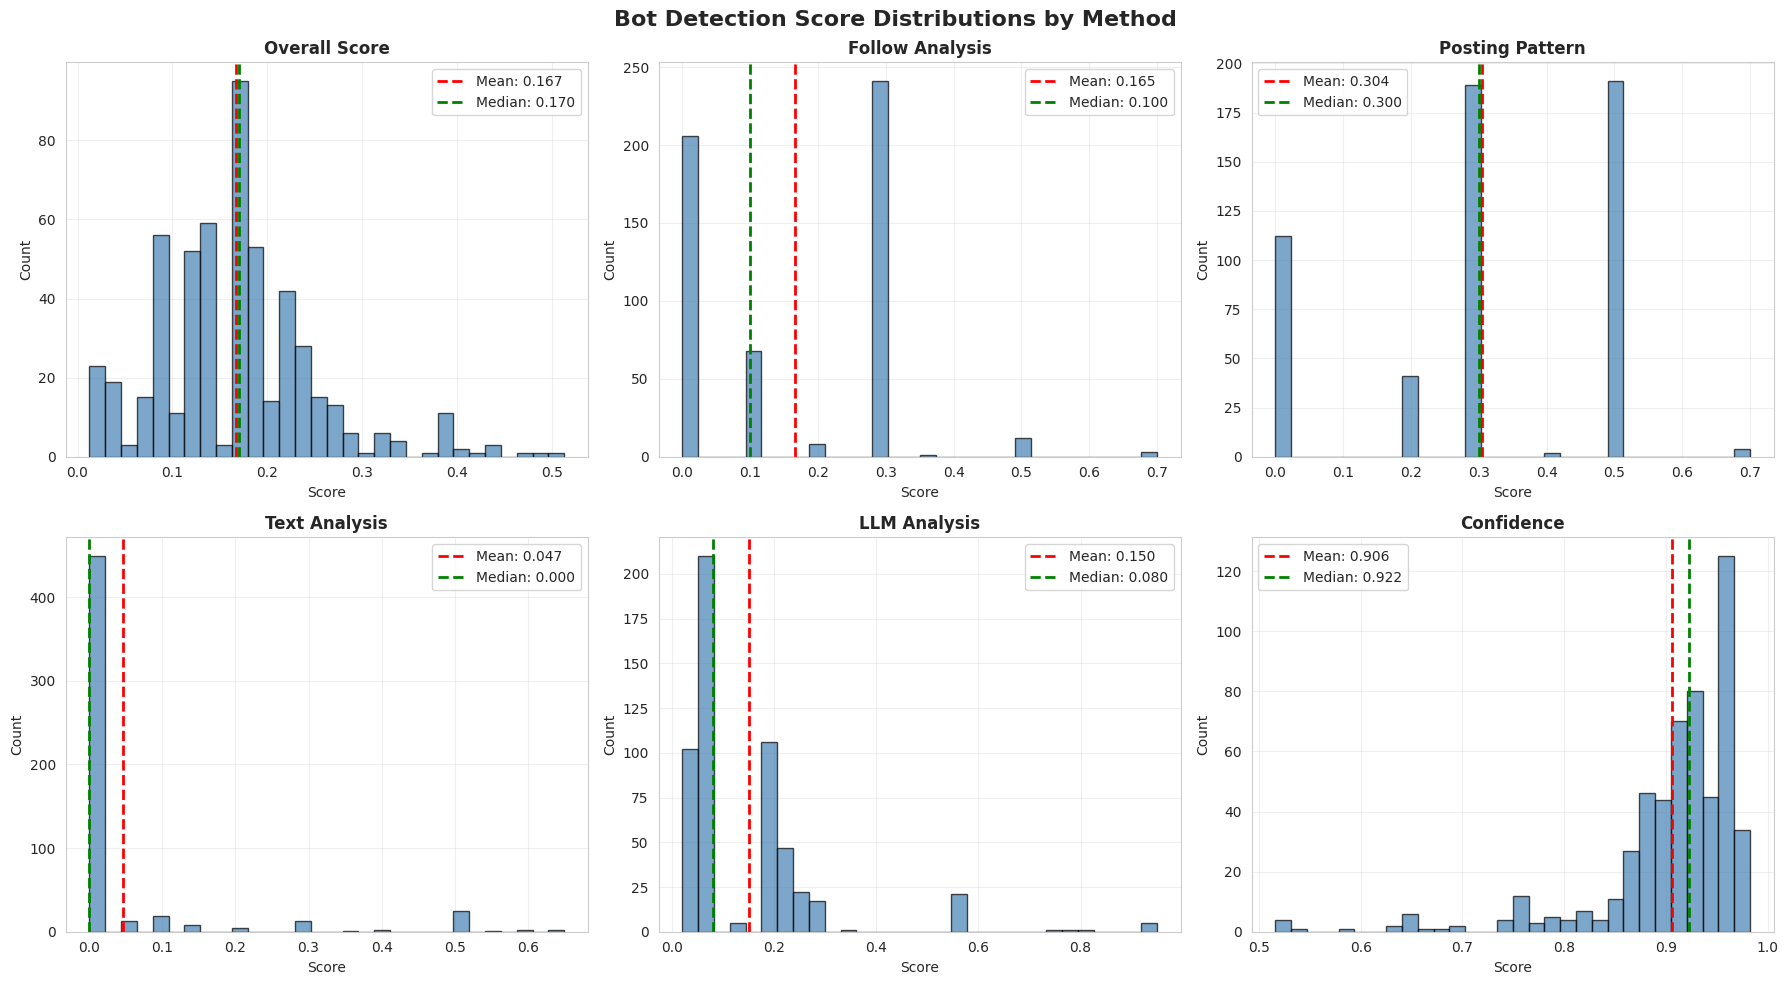

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Bot Detection Score Distributions by Method', fontsize=16, fontweight='bold')

methods = [
    ('overall_score', 'Overall Score'),
    ('follow_analysis_score', 'Follow Analysis'),
    ('posting_pattern_score', 'Posting Pattern'),
    ('text_analysis_score', 'Text Analysis'),
    ('llm_analysis_score', 'LLM Analysis'),
    ('confidence', 'Confidence')
]

for idx, (col, title) in enumerate(methods):
    ax = axes[idx // 3, idx % 3]
    
    # Histogram
    ax.hist(bot_results[col].dropna(), bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(bot_results[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {bot_results[col].mean():.3f}')
    ax.axvline(bot_results[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {bot_results[col].median():.3f}')
    
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Method Correlations

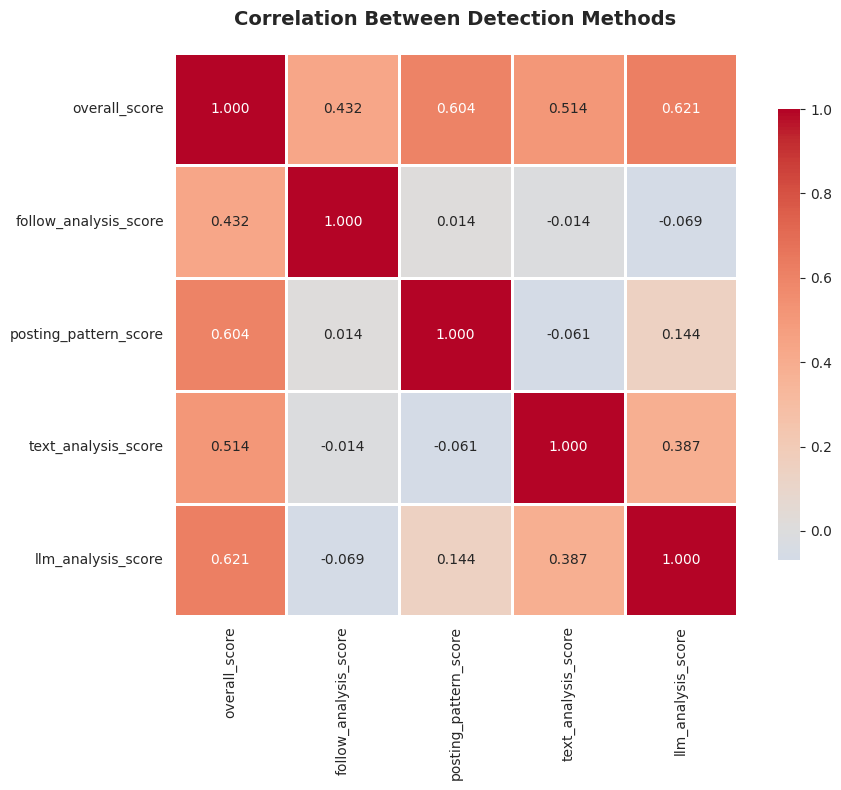


Correlation Insights:
  overall_score <-> posting_pattern_score: 0.604 (Moderate)
  overall_score <-> text_analysis_score: 0.514 (Moderate)
  overall_score <-> llm_analysis_score: 0.621 (Moderate)


In [22]:
# Calculate correlation matrix
score_cols = ['overall_score', 'follow_analysis_score', 'posting_pattern_score', 
              'text_analysis_score', 'llm_analysis_score']
corr_matrix = bot_results[score_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Between Detection Methods', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
for i, method1 in enumerate(score_cols[:-1]):
    for method2 in score_cols[i+1:]:
        corr_val = corr_matrix.loc[method1, method2]
        if abs(corr_val) > 0.5:
            print(f"  {method1} <-> {method2}: {corr_val:.3f} ({'Strong' if abs(corr_val) > 0.7 else 'Moderate'})")

## 5. Top Likely Bots

TOP 20 MOST LIKELY BOTS
                     handle  overall_score  confidence  follow_analysis_score  posting_pattern_score  text_analysis_score  llm_analysis_score                                                                                                                                          summary
       eriklund.bsky.social         0.5125    0.582708                    0.5                    0.5                  0.5                0.55        Analysis of @eriklund.bsky.social indicates this account is unclear - needs further investigation (risk level: MEDIUM, score: 0.51/1.00).
alimadhoun21-05.bsky.social         0.4875    0.539375                    0.7                    0.2                  0.5                0.55 Analysis of @alimadhoun21-05.bsky.social indicates this account is unclear - needs further investigation (risk level: MEDIUM, score: 0.49/1.00).
        ccolter.bsky.social         0.4625    0.804375                    0.3                    0.5               

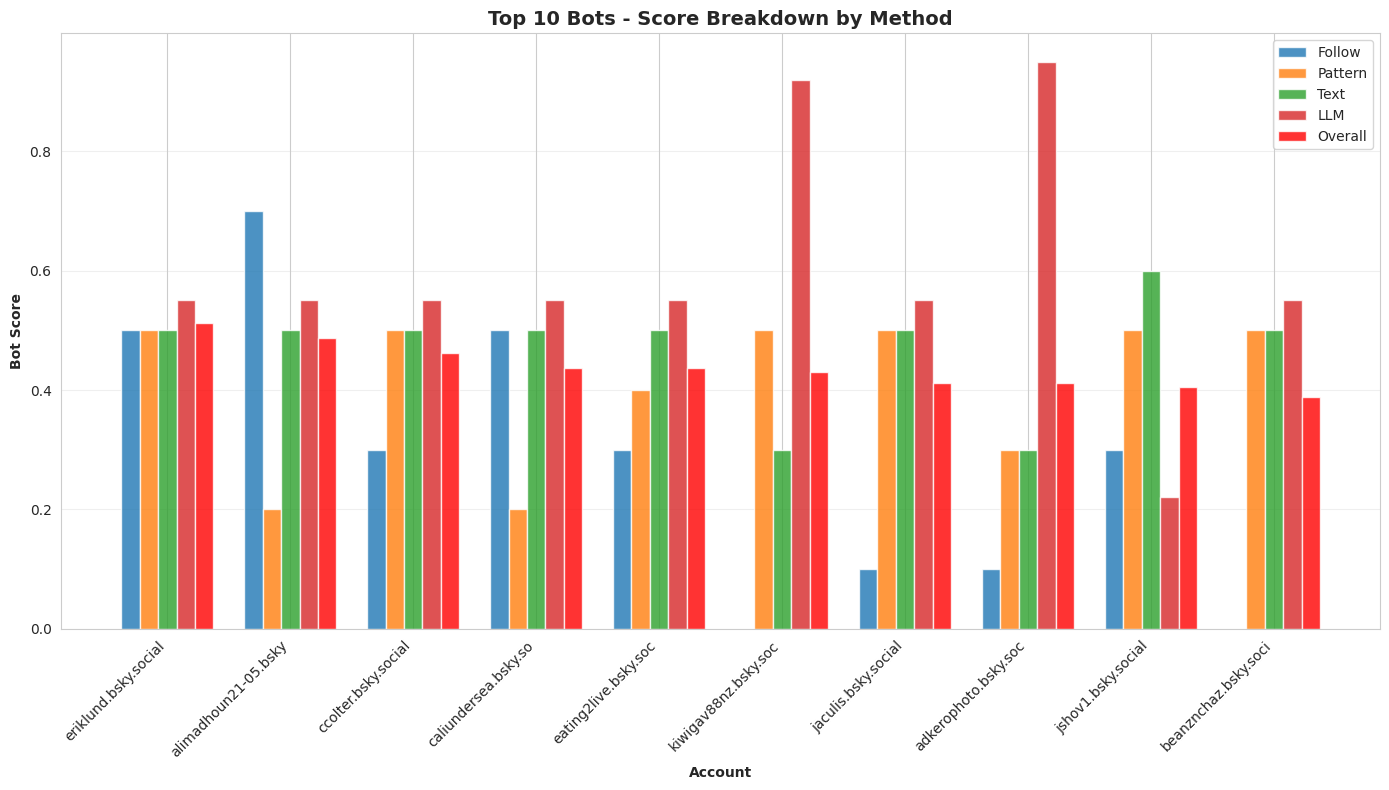

In [23]:
# Top 20 most likely bots
top_bots = bot_results.nlargest(20, 'overall_score')[[
    'handle', 'overall_score', 'confidence', 'follow_analysis_score', 
    'posting_pattern_score', 'text_analysis_score', 'llm_analysis_score','summary'
]]

print("=" * 100)
print("TOP 20 MOST LIKELY BOTS")
print("=" * 100)
print(top_bots.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))
top_10 = bot_results.nlargest(10, 'overall_score')
x = range(len(top_10))
width = 0.15

ax.bar([i - 2*width for i in x], top_10['follow_analysis_score'], width, label='Follow', alpha=0.8)
ax.bar([i - width for i in x], top_10['posting_pattern_score'], width, label='Pattern', alpha=0.8)
ax.bar(x, top_10['text_analysis_score'], width, label='Text', alpha=0.8)
ax.bar([i + width for i in x], top_10['llm_analysis_score'], width, label='LLM', alpha=0.8)
ax.bar([i + 2*width for i in x], top_10['overall_score'], width, label='Overall', alpha=0.8, color='red')

ax.set_xlabel('Account', fontweight='bold')
ax.set_ylabel('Bot Score', fontweight='bold')
ax.set_title('Top 10 Bots - Score Breakdown by Method', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([h[:20] for h in top_10['handle']], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. LLM Prompt Analysis (DeepSeek + Claude)

In [24]:
# Pivot data for analysis (now includes Claude)
prompt_pivot = all_prompts.pivot_table(
    index='handle',
    columns='prompt_name',
    values=['assessment', 'confidence'],
    aggfunc='first'
)

# Count assessments per prompt (including Claude)
prompt_counts = all_prompts.groupby(['prompt_name', 'assessment']).size().unstack(fill_value=0)

print("=" * 60)
print("PROMPT ANALYSIS (DeepSeek + Claude)")
print("=" * 60)
print("\nAssessment counts by prompt:")
print(prompt_counts)

# Calculate bot detection rate per prompt (including Claude)
prompt_bot_rate = all_prompts[all_prompts['assessment'] == 'ai_bot'].groupby('prompt_name').size() / all_prompts.groupby('prompt_name').size()
print("\nBot detection rate by prompt:")
for prompt, rate in prompt_bot_rate.sort_index().items():
    print(f"  {prompt}: {rate*100:.1f}%")

NameError: name 'all_prompts' is not defined

In [ ]:
# Visualize prompt comparisons (including Claude)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Assessment distribution
prompt_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Assessments by Prompt (DeepSeek + Claude)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Prompt', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].legend(['Human', 'AI Bot'])
axes[0].grid(True, alpha=0.3, axis='y')

# Average confidence by prompt and assessment
conf_by_prompt = all_prompts.groupby(['prompt_name', 'assessment'])['confidence'].mean().unstack(fill_value=0)
conf_by_prompt.plot(kind='bar', ax=axes[1], color=['green', 'red'], alpha=0.7)
axes[1].set_title('Average Confidence by Prompt (DeepSeek + Claude)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Prompt', fontweight='bold')
axes[1].set_ylabel('Confidence Score', fontweight='bold')
axes[1].legend(['Human', 'AI Bot'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Agreement Between All Prompts (DeepSeek + Claude)

In [ ]:
# Check how often prompts agree (now includes Claude)
prompt_assessments = all_prompts.pivot_table(
    index='handle',
    columns='prompt_name',
    values='assessment',
    aggfunc='first'
)

# Convert to binary (1 = ai_bot, 0 = human)
prompt_binary = (prompt_assessments == 'ai_bot').astype(int)

# Calculate agreement matrix
agreement_matrix = pd.DataFrame(index=prompt_binary.columns, columns=prompt_binary.columns)

for p1 in prompt_binary.columns:
    for p2 in prompt_binary.columns:
        if p1 == p2:
            agreement_matrix.loc[p1, p2] = 1.0
        else:
            # Calculate agreement rate
            agreement = (prompt_binary[p1] == prompt_binary[p2]).sum() / len(prompt_binary)
            agreement_matrix.loc[p1, p2] = agreement

agreement_matrix = agreement_matrix.astype(float)

# Plot agreement heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Prompt Agreement Matrix (DeepSeek + Claude)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nPrompt Agreement Insights (including Claude):")
for i, p1 in enumerate(prompt_binary.columns[:-1]):
    for p2 in prompt_binary.columns[i+1:]:
        agree_rate = agreement_matrix.loc[p1, p2]
        print(f"  {p1} <-> {p2}: {agree_rate*100:.1f}% agreement")

In [ ]:
# Check how often prompts agree
prompt_assessments = deepseek.pivot_table(
    index='handle',
    columns='prompt_name',
    values='assessment',
    aggfunc='first'
)

# Convert to binary (1 = ai_bot, 0 = human)
prompt_binary = (prompt_assessments == 'ai_bot').astype(int)

# Calculate agreement matrix
agreement_matrix = pd.DataFrame(index=prompt_binary.columns, columns=prompt_binary.columns)

for p1 in prompt_binary.columns:
    for p2 in prompt_binary.columns:
        if p1 == p2:
            agreement_matrix.loc[p1, p2] = 1.0
        else:
            # Calculate agreement rate
            agreement = (prompt_binary[p1] == prompt_binary[p2]).sum() / len(prompt_binary)
            agreement_matrix.loc[p1, p2] = agreement

agreement_matrix = agreement_matrix.astype(float)

# Plot agreement heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('DeepSeek Prompt Agreement Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nPrompt Agreement Insights:")
for i, p1 in enumerate(prompt_binary.columns[:-1]):
    for p2 in prompt_binary.columns[i+1:]:
        agree_rate = agreement_matrix.loc[p1, p2]
        print(f"  {p1} <-> {p2}: {agree_rate*100:.1f}% agreement")

## 8. Comparison: Our Detection vs DeepSeek

In [ ]:
# Merge bot detection with DeepSeek majority vote
deepseek_votes = prompt_binary.sum(axis=1) / len(prompt_binary.columns)  # Fraction voting "bot"

comparison = bot_results[['handle', 'overall_score']].copy()
comparison = comparison.merge(deepseek_votes.reset_index().rename(columns={0: 'deepseek_bot_fraction'}), 
                              on='handle', how='inner')

# Plot comparison
plt.figure(figsize=(12, 8))
plt.scatter(comparison['overall_score'], comparison['deepseek_bot_fraction'], 
           alpha=0.5, s=50, edgecolors='black', linewidth=0.5)

# Add diagonal line for perfect agreement
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')

# Add correlation
corr = comparison['overall_score'].corr(comparison['deepseek_bot_fraction'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('Our Bot Detection Score', fontweight='bold', fontsize=12)
plt.ylabel('DeepSeek Bot Vote Fraction', fontweight='bold', fontsize=12)
plt.title('Comparison: Our Detection vs DeepSeek Analysis', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nCorrelation between our score and DeepSeek: {corr:.3f}")
print(f"\nAgreement on strong cases:")
print(f"  Both say bot (our >0.6, DS >0.5): {len(comparison[(comparison['overall_score'] > 0.6) & (comparison['deepseek_bot_fraction'] > 0.5)])}")
print(f"  Both say human (our <0.4, DS <0.5): {len(comparison[(comparison['overall_score'] < 0.4) & (comparison['deepseek_bot_fraction'] < 0.5)])}")
print(f"  Disagreement (our >0.6 but DS <0.5): {len(comparison[(comparison['overall_score'] > 0.6) & (comparison['deepseek_bot_fraction'] < 0.5)])}")
print(f"  Disagreement (our <0.4 but DS >0.5): {len(comparison[(comparison['overall_score'] < 0.4) & (comparison['deepseek_bot_fraction'] > 0.5)])}")

In [ ]:
# Create summary report
summary_report = f"""
====================================================================
                BOT DETECTION ANALYSIS SUMMARY REPORT
====================================================================

Dataset Size:
  - Total users analyzed: {len(bot_results)}
  - Total LLM analyses (DeepSeek + Claude): {len(all_prompts)}

Our Bot Detection Results:
  - Mean overall score: {bot_results['overall_score'].mean():.3f}
  - Classified as bots (score >= 0.6): {len(bot_results[bot_results['overall_score'] >= 0.6])} ({len(bot_results[bot_results['overall_score'] >= 0.6])/len(bot_results)*100:.1f}%)
  - Classified as humans (score <= 0.4): {len(bot_results[bot_results['overall_score'] <= 0.4])} ({len(bot_results[bot_results['overall_score'] <= 0.4])/len(bot_results)*100:.1f}%)
  - Uncertain (0.4 < score < 0.6): {len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])} ({len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])/len(bot_results)*100:.1f}%)

Method Scores (Mean):
  - Follow analysis: {bot_results['follow_analysis_score'].mean():.3f}
  - Posting pattern: {bot_results['posting_pattern_score'].mean():.3f}
  - Text analysis: {bot_results['text_analysis_score'].mean():.3f}
  - LLM analysis: {bot_results['llm_analysis_score'].mean():.3f}

LLM Analysis (DeepSeek + Claude):
  - Bot detection rates by prompt:
{chr(10).join([f'    - {p}: {r*100:.1f}%' for p, r in prompt_bot_rate.sort_index().items()])}

Agreement:
  - Correlation (Our vs DeepSeek): {corr:.3f}
  - Both agree on bots: {len(comparison[(comparison['overall_score'] > 0.6) & (comparison['deepseek_bot_fraction'] > 0.5)])}
  - Both agree on humans: {len(comparison[(comparison['overall_score'] < 0.4) & (comparison['deepseek_bot_fraction'] < 0.5)])}

====================================================================
"""

print(summary_report)

# Save to file
with open('analysis_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Summary report saved to 'analysis_summary_report.txt'")

In [ ]:
# Create summary report
summary_report = f"""
====================================================================
                BOT DETECTION ANALYSIS SUMMARY REPORT
====================================================================

Dataset Size:
  - Total users analyzed: {len(bot_results)}
  - Total DeepSeek analyses: {len(deepseek)}

Our Bot Detection Results:
  - Mean overall score: {bot_results['overall_score'].mean():.3f}
  - Classified as bots (score >= 0.6): {len(bot_results[bot_results['overall_score'] >= 0.6])} ({len(bot_results[bot_results['overall_score'] >= 0.6])/len(bot_results)*100:.1f}%)
  - Classified as humans (score <= 0.4): {len(bot_results[bot_results['overall_score'] <= 0.4])} ({len(bot_results[bot_results['overall_score'] <= 0.4])/len(bot_results)*100:.1f}%)
  - Uncertain (0.4 < score < 0.6): {len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])} ({len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])/len(bot_results)*100:.1f}%)

Method Scores (Mean):
  - Follow analysis: {bot_results['follow_analysis_score'].mean():.3f}
  - Posting pattern: {bot_results['posting_pattern_score'].mean():.3f}
  - Text analysis: {bot_results['text_analysis_score'].mean():.3f}
  - LLM analysis: {bot_results['llm_analysis_score'].mean():.3f}

DeepSeek Analysis:
  - Bot detection rates by prompt:
{chr(10).join([f'    - {p}: {r*100:.1f}%' for p, r in prompt_bot_rate.items()])}

Agreement:
  - Correlation (Our vs DeepSeek): {corr:.3f}
  - Both agree on bots: {len(comparison[(comparison['overall_score'] > 0.6) & (comparison['deepseek_bot_fraction'] > 0.5)])}
  - Both agree on humans: {len(comparison[(comparison['overall_score'] < 0.4) & (comparison['deepseek_bot_fraction'] < 0.5)])}

====================================================================
"""

print(summary_report)

# Save to file
with open('analysis_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Summary report saved to 'analysis_summary_report.txt'")

In [ ]:
# Close database connection
conn.close()
print("\n✓ Analysis complete!")

In [ ]:
#Get most likely bots combined deepseek scores
most_likely_bots_deepseek = deepseek.groupby('handle').apply(lambda df: (df['assessment'] == 'ai_bot').mean()).reset_index()
most_likely_bots_deepseek.columns = ['handle', 'bot_vote_fraction']
most_likely_bots_deepseek = most_likely_bots_deepseek.sort_values(by='bot_vote_fraction', ascending=False).head(20)
print("=" * 100)
print("TOP 20 MOST LIKELY BOTS BASED ON DEEPSEEK SCORES")
print("=" * 100)
print(most_likely_bots_deepseek.to_string(index=False)) 
